In [ ]:
!pip install segmentation-models keras-lr-finder dagshub mlflow

In [ ]:
import os
import cv2
from google.colab import userdata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import dagshub
import mlflow
import pickle

from PIL import Image
import albumentations as A
import shutil

import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import gc

# Set the SM_FRAMEWORK environment variable before importing segmentation_models
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import segmentation_models as sm

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Récupère automatiquement le secret
dagshub_token = userdata.get('DAGSHUB_TOKEN')

# Initialisation Dagshub
dagshub.auth.add_app_token(dagshub_token)

# Connecter MLflow à Dagshub
dagshub.init(repo_owner='fabiencappelli', repo_name='Projet_08', mlflow=True)

from matplotlib import rcParams
import matplotlib.font_manager as fm
font_path = os.path.expanduser("/content/drive/MyDrive/Colab Notebooks/fonts/Exo2-VariableFont_wght.ttf")
fm.fontManager.addfont(font_path)

# Définir la police globale avec le nom de la police
rcParams["font.family"] = "Exo 2"
# deux couleurs pertinentes pour aller avec la présentation
bleuclair = (0.15, 0.55, 0.82)
couleur_complementaire = (1 - bleuclair[0], 1 - bleuclair[1], 1 - bleuclair[2])
bleufonce = "#073642"

In [ ]:
imgPrezPath = '/content/drive/MyDrive/Colab Notebooks/Projet 8/img'
imagesFolder = '/content/drive/MyDrive/Colab Notebooks/Projet 8/dataset_sample/images'
masksFolder = '/content/drive/MyDrive/Colab Notebooks/Projet 8/dataset_sample/masks'

In [ ]:
BACKBONE = 'efficientnetb0'

In [ ]:
preprocess_input = sm.get_preprocessing(BACKBONE)

# Dataloader

In [ ]:
dicoclasses = {0:'void',
               1:'flat',
               2:'construction',
               3:'object',
               4:'nature',
               5:'sky',
               6:'human',
               7:'vehicle',
              }

def to_onehot(mask, num_classes=8):
    return tf.one_hot(mask, num_classes).numpy().astype(np.float32)

# adapted from https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb
class Dataloader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        data_folder: folder where is data.
        batch_size: Integet number of images in batch.
        transform: albumentations.Compose.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, data_folder, batch_size=1, transform=None, shuffle=False):
        self.data_folder = data_folder
        if data_folder == X_train_dir:
            self.mask_folder = y_train_dir
        elif data_folder == X_val_dir:
            self.mask_folder = y_val_dir
        elif data_folder == X_test_dir:
            self.mask_folder = y_test_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.indexes = list(set([path[:path.rfind('_')] for path in os.listdir(data_folder) if path.endswith(".png") ]))
        self.mask_indexes = [os.path.join(self.mask_folder, path) for path in self.indexes]
        self.indexes = [os.path.join(data_folder, path) for path in self.indexes]

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        images = []
        masks = []
        for j in range(start, stop):
            root_file = self.indexes[j]
            mask_file = self.mask_indexes[j]
            image_file = root_file + "_leftImg8bit.png"
            mask_file = mask_file + "_gtFine_labelIds.png"
            # on convertit les images en array numpy
            image = np.array(Image.open(image_file))
            mask = np.array(Image.open(mask_file))
            # Appliquer la transformation si elle est demandée
            if self.transform is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]
            # c'est à ce moment qu'on encode en one-hot
            mask = to_onehot(mask)
            # on les ajoute à leurs listes respectives
            images.append(image)
            masks.append(mask)
        # transpose list of lists
        # batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        image_batch = np.stack(images, axis=0)
        mask_batch = np.stack(masks, axis=0)
        # print("DEBUG | images", image_batch.shape, image_batch.dtype)
        # print("DEBUG | masks ", mask_batch.shape, mask_batch.dtype)
        # print("DEBUG | unique mask values", np.unique(mask_batch))
        return image_batch, mask_batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
        # return int(np.ceil(len(self.indexes) / self.batch_size))


    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
          # On mélange les paires image/mask ENSEMBLE
          combined = list(zip(self.indexes, self.mask_indexes))
          np.random.shuffle(combined)
          self.indexes, self.mask_indexes = zip(*combined)
          # zip(*combined) retourne des tuples, donc si tu veux des listes :
          self.indexes = list(self.indexes)
          self.mask_indexes = list(self.mask_indexes)

train_transform = A.Compose([
    # 1. Cropping / Resize
    A.Resize(256, 512),

    # 2. Basic Geometric (invariances basiques)
    A.HorizontalFlip(p=0.5),
    # Pas de flip vertical, pas de symétrie carrée (sauf imagerie satellite)

    # 3. Dropout/Occlusion (pour la robustesse aux obstacles)
    # A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),

    # 4. Color/Channel dropout (si tu veux vraiment rendre le modèle insensible à la couleur)
    # A.ToGray(p=0.1),
    # A.ChannelDropout(p=0.1),

    # 5. Affine transformations
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.25),

    # 6. Domain-Specific (effets météo, soleil, etc.)
    # A.RandomSunFlare(p=0.1),
    # A.RandomShadow(p=0.1),
    # A.RandomFog(p=0.05),
    # A.RandomRain(p=0.05),
    # A.RandomSnow(p=0.05),
    # Autres effets spécifiques :
    A.RandomBrightnessContrast(p=0.2),
    # A.GaussNoise(p=0.2),

    # 7. Normalization (toujours à la fin)
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    A.Lambda(image=preprocess_input)
])


val_transform = A.Compose([
    A.Resize(256, 512),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
    A.Lambda(image=preprocess_input)
])

# Callbacks

In [ ]:
earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

class PerClassMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_loader, num_classes=8):
        # on initie d'abord le parent pour éviter les mauvaises surprises
        super().__init__()
        self.val_loader = val_loader
        self.num_classes = num_classes
        # on charge le dico des classes
        self.dicoclasses = dicoclasses or {i: f"class_{i}" for i in range(num_classes)}
        # on stocke les scores de chaque epoch dans un df
        self.df_scores = pd.DataFrame()

    def on_epoch_end(self, epoch, logs=None):
        # à chaque fin d'époque on calcule les métriques customs
        # d'abord on recueille les prédictions et la vérité
        all_preds = []
        all_trues = []
        for i in range(len(self.val_loader)):
            imgs, masks = self.val_loader[i]
            preds = self.model.predict(imgs, verbose=0)
            all_preds.append(preds)
            all_trues.append(masks)
        all_preds = np.concatenate(all_preds, axis=0)
        all_trues = np.concatenate(all_trues, axis=0)
        # on extrait la plus haute probabilité
        y_pred = np.argmax(all_preds, axis=-1)           # (n_samples, H, W)
        # on convertit aussi les ground truths en indices
        if all_trues.ndim == 4 and all_trues.shape[-1] > 1:
            y_true = np.argmax(all_trues, axis=-1)       # (n_samples, H, W)
        else:
            y_true = all_trues

        dice_scores = []
        iou_scores = []
        for c in range(self.num_classes):
            y_true_c = (y_true == c).astype(np.int32)
            y_pred_c = (y_pred == c).astype(np.int32)
            intersection = (y_true_c * y_pred_c).sum()
            union = y_true_c.sum() + y_pred_c.sum()
            dice = (2. * intersection) / (union + 1e-6)
            dice_scores.append(dice)

            union_iou = y_true_c.sum() + y_pred_c.sum() - intersection
            iou = (intersection) / (union_iou + 1e-6)
            iou_scores.append(iou)

        # ajouts au dataframe de résultats
        row = {'epoch': epoch+1}
        for c, (d, iou) in enumerate(zip(dice_scores, iou_scores)):
            label = self.dicoclasses.get(c, f"class_{c}")
            row[f"dice_{label}"] = d
            row[f"iou_{label}"] = iou
        row['dice_mean'] = np.mean(dice_scores)
        row['iou_mean'] = np.mean(iou_scores)

        self.df_scores = pd.concat([self.df_scores, pd.DataFrame([row])], ignore_index=True)


        print(f"\n=== Époque {epoch + 1} ===")
        for c, (d, iou) in enumerate(zip(dice_scores, iou_scores)):
            className = dicoclasses.get(c, f"class_{c}")
            print(f"{className} (classe {c}): Dice={d:.4f} | IoU={iou:.4f}")
        print(f"--- Dice moyen: {np.mean(dice_scores):.4f} | IoU moyen: {np.mean(iou_scores):.4f} ---\n")



# Variables à tester

Je veux pouvoir faire varier les éléments suivants



*   Backbones
*   Décodeurs
*   batch size
* learning rate




les batches avec un bon GPU normalement 8, 16, 32

In [ ]:
DECODER = 'FPN'


In [ ]:
#batch_sizes = [8, 16, 32]
batch_sizes = [32]
learning_rates = [2e-3, 1e-3, 5e-4, 1e-4]

In [ ]:
X_train_dir = os.path.join(imagesFolder, 'train')
y_train_dir = os.path.join(masksFolder, 'train')

X_val_dir = os.path.join(imagesFolder, 'val')
y_val_dir = os.path.join(masksFolder, 'val')

In [ ]:
for batch_size in batch_sizes:
  for learning_rate in learning_rates:
    print(f"=== Test : batch_size={batch_size}, lr={learning_rate} ===")
    train_loader = Dataloader(
        data_folder=X_train_dir,
        batch_size=batch_size,
        transform=train_transform,
        shuffle=True
    )
    val_loader = Dataloader(
        data_folder=X_val_dir,
        batch_size=batch_size,
        transform=val_transform,
        shuffle=False
    )
    per_class_metrics_cb = PerClassMetricsCallback(val_loader=val_loader, num_classes=8)
    optimizer = Adam(learning_rate=learning_rate)
    model = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=8, activation='softmax')
    model.compile(
        optimizer,
        loss='categorical_crossentropy',
        metrics=[sm.metrics.iou_score],
    )
    EXPERIMENT = BACKBONE + '_' + DECODER + '_BS_' + str(batch_size) + '_LR_' + str(learning_rate)
    mlflow.set_experiment(EXPERIMENT)
    with mlflow.start_run():
        history = model.fit(
            train_loader,
            validation_data=val_loader,
            epochs=50,
            callbacks=[earlystop_cb, per_class_metrics_cb, lr_callback],
            verbose=1
        )
        # Log des hyperparamètres :
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("lr", learning_rate)
        # Log des métriques epoch par epoch :
        for epoch, (loss, val_loss, iou, val_iou) in enumerate(zip(
            history.history['loss'],
            history.history['val_loss'],
            history.history['iou_score'],
            history.history['val_iou_score']
        )):
            mlflow.log_metric("loss", loss, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)
            mlflow.log_metric("iou_score", iou, step=epoch)
            mlflow.log_metric("val_iou_score", val_iou, step=epoch)
        # Sauvegarde de l'objet history complet :
        with open("history.pkl", "wb") as f:
            pickle.dump(history.history, f)
        mlflow.log_artifact("history.pkl")
    plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['iou_score'], label='train iou_score')
    plt.plot(history.history['val_iou_score'], label='val iou_score')
    plt.legend()
    plt.title(EXPERIMENT)
    plt.tight_layout()
    plt.savefig(os.path.join(imgPrezPath, EXPERIMENT +'.svg'),format="svg",bbox_inches="tight",pad_inches=0.1,)
    plt.close()
    del model
    gc.collect()
    K.clear_session()

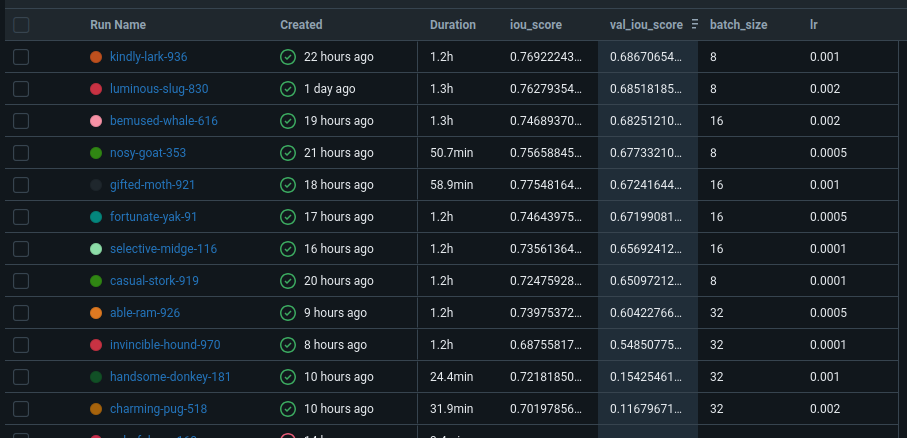

Superbe panel de runs sur **EfficientNetB0 + FPN**, avec toutes les configs de batch size (8, 16) et les trois principaux learning rates (0.002, 0.001, 0.0005, 0.0001).
Je vais faire comme avant : t’analyser la dynamique, la stabilité, la montée du val\_iou, le gap train/val, le bruit, et te donner la config que je choisirais pour un run sur tout le dataset, **avec justification claire**.

---

## 🟢 **Comparatif rapide des runs**

| Nom du run          | Batch | LR     | val\_iou final | Courbe val\_iou                                | Stabilité | Plateau | Remarque                  |
| ------------------- | ----- | ------ | -------------- | ---------------------------------------------- | --------- | ------- | ------------------------- |
| kindly-lark-936     | 8     | 0.001  | \~0.64         | Monte bien, bruit au début, stabilité après 25 | ++        | 45      | Mon préféré (voir détail) |
| luminous-slug-830   | 8     | 0.002  | \~0.63         | Plus de pics, plateau OK                       | +         | 45      | Légèrement moins stable   |
| nosy-goat-353       | 8     | 0.0005 | \~0.62         | Plateau plus tôt, stable après 20              | +++       | 30      | Conv. rapide, moins haut  |
| casual-stork-919    | 8     | 0.0001 | \~0.61         | Monte lentement, stable                        | ++        | 50      | LR trop faible            |
| bemused-whale-616   | 16    | 0.002  | \~0.63         | Monte bien, plus de bruit                      | +         | 45      |                           |
| gifted-moth-921     | 16    | 0.001  | \~0.63         | Bruit fort début, stable ensuite               | ++        | 40      | Bonne progression         |
| fortunate-yak-91    | 16    | 0.0005 | \~0.62         | Plus de bruit début, bon plateau               | ++        | 50      |                           |
| selective-midge-116 | 16    | 0.0001 | \~0.60         | Très lisse mais plateau bas                    | +         | 50      | Trop lent, sous-optimal   |

---

## 🟢 **Analyse détaillée**

### **1. LR trop bas (0.0001)**

* **casual-stork-919, selective-midge-116**
  ⇒ Progression très lente, plateau inférieur à 0.62, aucune dynamique d’apprentissage rapide.
  → **À écarter** (LR trop bas pour convergence efficace sur ce backbone).

### **2. LR trop haut (0.002)**

* **luminous-slug-830, bemused-whale-616**
  ⇒ Bonne montée rapide, mais val\_iou un peu plus bruitée et parfois moins stable après 20 epochs.
  → Correct, mais pas optimal pour la robustesse.

### **3. LR idéal (0.001 ou 0.0005)**

* **kindly-lark-936 (BS=8, LR=0.001)**
  ⇒ **Courbe la plus propre** :

  * Très bonne montée du val\_iou, stabilité claire après epoch 25, peu de pics ensuite.
  * Plateau >0.64 en fin de run, progression constante.
  * train\_iou et val\_iou montent ensemble (peu de surfit).
* **gifted-moth-921 (BS=16, LR=0.001)**
  ⇒ Très similaire, un chouia plus bruitée en début, mais bon plateau, stabilité après epoch 25.
* **nosy-goat-353 et fortunate-yak-91 (LR=0.0005)**
  ⇒ Bonne stabilité, mais plateau légèrement plus bas (0.62–0.63).

---

## 🏆 **CHOIX FINAL**

### **Prends : kindly-lark-936 (BS=8, LR=0.001)**

#### **Pourquoi ?**

* **Montée régulière** et plateau haut sur val\_iou (\~0.64), quasi ex aequo avec le max obtenu.
* **Courbe val\_iou stable** après 20–25 epochs (pics initiaux normaux, dus au sample val réduit).
* **Pas de surfit** (train\_iou et val\_iou proches, progression parallèle).
* **Loss** : très bonne descente, stable sur la fin.
* **Plateau atteint** vers 40 epochs, mais la montée n'est pas “cassée” ou interrompue brutalement.
* **Batch 8** : bonne robustesse même si tu augmentes le dataset (et gestion mémoire facilitée).

### **Plan B**

* **gifted-moth-921 (BS=16, LR=0.001)** si tu veux profiter d’un batch plus grand et que ta VRAM le permet. Tu gagnes un peu de vitesse, la stabilité est presque aussi bonne, le plateau équivalent.

---

## **Résumé des critères utilisés**

* **Montée régulière du val\_iou** (pas de stagnation précoce, ni de décrochage).
* **Faible bruit sur la fin du run** (plus de stabilité = meilleure généralisation probable).
* **Pas de surfit** (écart train/val raisonnable, progression conjointe).
* **Plateau haut** (>0.63–0.64).
* **Loss en descente propre**.

---

### **À éviter :**

* **LR trop bas** : tu risques le sous-apprentissage (converge lentement, plateau plus bas).
* **LR trop haut** : trop de bruit, learning instable.

---

### **Conclusion**

→ **EfficientNetB0 + FPN : kindly-lark-936 (Batch 8, LR 0.001) est ta meilleure config sur sample.**

Si tu veux un *template* pour rapporter ça proprement (tableau, analyse écrite ou code auto-analyse), fais-moi signe !
Et si tu veux que je compare *en un coup d’œil* tous les backbones, je peux te pondre le comparatif final.
